In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("openai/webgpt_comparisons", cache_dir = '../hf-data')

Found cached dataset webgpt_comparisons (/mnt/sairam/raithubot-training/testing/../hf-data/openai___webgpt_comparisons/default/0.0.0/8b5d5879cdc98c4c0099af6053dffe8d504588d43d3b11f1b1ec223ab1e8db0a)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
dataset['train'][0].keys()

dict_keys(['question', 'quotes_0', 'answer_0', 'tokens_0', 'score_0', 'quotes_1', 'answer_1', 'tokens_1', 'score_1'])

In [4]:
dataset['train'][0]['question']['full_text']

'Voiced by Harry Shearer, what Simpsons character was modeled after Ted Koppel?'

In [6]:
dataset['train'][0]['answer_0']

'The Simpsons character that was possibly based on Ted Koppel is Kent Brockman.  He is a local news anchor in Springfield and is modeled after Ted Koppel. [1]'

In [7]:
dataset['train'][0]['answer_1']

"Apu Nahasapeemapetilon is a recurring character in the American animated television series The Simpsons. He is an Indian immigrant proprietor who runs the Kwik-E-Mart, a popular convenience store in Springfield. [1] He was based on Peter Seller's character in the film The Party. [2]"

In [14]:
score_dist = []

In [15]:
for i in range(1000):
    score_dist.append(dataset['train'][i]['score_1'])

(array([ 81.,   4., 256.,  16.,   0., 299.,  18., 253.,  10.,  63.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

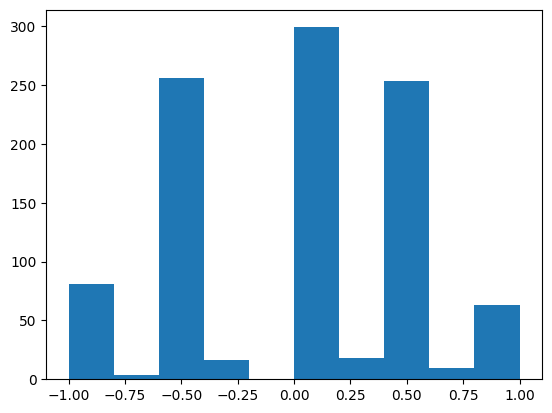

In [16]:
import matplotlib.pyplot as plt
plt.hist(score_dist)

In [1]:
import jsonlines

In [2]:
with open("../kcc_data/jsonlines/trimmed.jsonl", 'r') as reader:
        data = [i[1:-2] for i in reader]

In [3]:
import numpy as np

In [4]:
records = []

In [5]:
for record in data:
    record_dict = {}
    query_start = record.find("<|query|>") + len("<|query|>")
    query_end = record.find("</query/>")
    record_dict['query'] = record[query_start:query_end]
    record = record[query_end + len("</query/>"):]
    
    record_dict['summaries'] = []
    while True:
        summary_dict = {}
        summary_start = record.find("<|summary|>") + len("<|summary|>")
        summary_end = record.find("</summary/>")
        if summary_end == -1:
            break
        
        summary_dict['summary'] = record[summary_start:summary_end]
        record = record[summary_end + len("</summary/>"):]
        
        
        while True:
            results_start = record.find("<|results|>") + len("<|results|>")
            results_end = record.find("</results/>")
            if results_end == -1:
                break
            
            results = record[results_start:results_end]
            record = record[results_end + len("</results/>"):]
            summary_dict['results'] = []
            
            while True:
                result_start = results.find("<|result|>") + len("<|result|>")
                result_end = results.find("</result/>")
                if result_end == -1:
                    break
                
                summary_dict['results'].append(results[result_start:result_end])
                
                results = results[result_end + len("</result/>"):]
        
        record_dict['summaries'].append(summary_dict)
    
    response_start = record.find("<|response|>") + len("<|response|>")
    response_end = record.find("</response/>")
    record_dict['response'] = record[response_start:response_end]
    records.append(record_dict)

In [6]:
records[1]

{'query': "I understand that paddy nutrient management is important, but I'm not sure how it works and how it can help me.",
 'summaries': [{'summary': 'paddy nutrient management',
   'results': ["Environmental Fate: What happens to the pesticide in soil, water, and air after being released into the environment.<|result-sentence|>Environmental Fate: What happens to the pesticide in soil, water, and air after being released into the environment.<|result-sentence|>The studies we use in our ecological risk assessments define the chemical properties of the pesticide, how the pesticide behaves in the environment, and its impact on plants and animals not targeted by the pesticide.<|result-sentence|>For plants, we look at how poisonous the pesticide is to plants, how the pesticide affects a seed's ability to germinate and emerge, as well as how healthy and vigorous the plant grows up.<|result-sentence|>The process of comparing toxicity information and the amount of the pesticide a given organ

In [7]:
results = []

In [8]:
import requests

def get_snippets_from_query(query, keys):
    api_key = keys['google_custom_search']
    search_engine_id = keys['search_engine_id']
    payload = {
        'key': api_key,
        'cx': search_engine_id,
        'q': query
    }
    req = requests.get("https://customsearch.googleapis.com/customsearch/v1", payload)
    try:
        items = req.json()['items'][:20]
    except KeyError:
        return None
    snippets = []
    for item in items:
        try:
            snippets.append(item['snippet'])
        except KeyError:
            continue
    return snippets[:5]

In [10]:
import json
with open('../api_keys.json', 'r') as f:
    keys = json.load(f)

In [12]:
from tqdm.auto import tqdm

In [13]:
for record in tqdm(records):
    query = record['query']
    response = record['response']
    snippets = get_snippets_from_query(query, keys)
    results.append({
        'query': query,
        'true_answer': response,
        'snippets': snippets
    })

  0%|          | 0/93 [00:00<?, ?it/s]

In [14]:
with jsonlines.open('../kcc_data/webgpt.jsonl', mode = 'a') as writer:
    for result in results:
        writer.write(result)

In [41]:
record_texts = []

In [42]:
for record in records:
    text = "<|query|>" + record['query'] + "</query/>"
    for summary in record['summaries']:
        text += '<|summary|>' + summary['summary'] + "</summary/>"
        text += '<|results|>'
        if len(summary['results']) > 3:
            summary['results'] = np.random.choice(summary['results'], 3, replace = False)
        
        for result in summary['results']:
            text += '<|result|>'
            text += result
            text += '</result/>'
        text += '</results/>'
    
    text += '<|response|>'
    text += record['response']
    text += '</response/>'
    record_texts.append(text)

In [45]:
with jsonlines.open('../kcc_data/jsonlines/trimmed.jsonl', 'w') as writer:
    for text in record_texts:
        writer.write(text)

In [30]:
len(all_results)

3

In [27]:
len(all_results)

3

In [8]:
for i in range(75):
    record = findithdatapoint(i)

AttributeError: 'list' object has no attribute 'find'

In [3]:
train_dataset = dataset['train']

In [4]:
train_dataset

Dataset({
    features: ['question', 'quotes_0', 'answer_0', 'tokens_0', 'score_0', 'quotes_1', 'answer_1', 'tokens_1', 'score_1'],
    num_rows: 19578
})

In [5]:
mystery = next(iter(train_dataset))

In [6]:
mystery['question']['full_text']

'Voiced by Harry Shearer, what Simpsons character was modeled after Ted Koppel?'

In [7]:
mystery['quotes_0']

{'title': ['Kent Brockman (en.wikipedia.org)',
  'Krusty the Clown (en.wikipedia.org)'],
 'extract': ['Kent Brockman is a fictional character in the animated television series The Simpsons. He is voiced by Harry Shearer and first appeared in the episode "Krusty Gets Busted". He is a grumpy, self-centered local Springfield news anchor.',
  "Krusty was created by cartoonist Matt Groening and partially inspired by Rusty Nails, a television clown from Groening's hometown of Portland, Oregon."]}

In [12]:
import os
import requests

In [31]:
payload = {
    'q': 'Voiced by Harry Shearer, what Simpsons character was modeled after Ted Koppel?',
    'key': os.environ['SEARCH_API_KEY'],
    'cx': os.environ['SEARCH_ENGINE']
}
resp = requests.get("https://customsearch.googleapis.com/customsearch/v1", payload)
req = requests.Request('GET', )

In [46]:
resp.json()['items'][1]['snippet']

'Kent Brockman is a fictional character in the animated television series The Simpsons. He is voiced by Harry Shearer and first appeared in the episode "Krusty ... designed the character and modeled him after anchorman Ted Koppel.'

In [50]:
list(mystery.keys())

['question',
 'quotes_0',
 'answer_0',
 'tokens_0',
 'score_0',
 'quotes_1',
 'answer_1',
 'tokens_1',
 'score_1']

In [55]:
mystery['score_1']

-1.0